# Intelligent Systems: Recognizing Digits using Neural Networks


### Authors 
- Folajimi OLANIYAN
- Carlos VARGAS
- Nairit BANDYOPADHYAY
- Manuel SULMONT

This is a study of the performance of two algorithms in the task of classification using the MNIST dataset which includes 70000 samples of handwritten digit images. The first algorithm is a Multi-layer Perceptron (MLP) and the second one is a Convolutional Neural Network (CNN) inspired in the classical LeNet architecture. The main frameworks used are Keras and Scikit-Learn.

# Part I : Training with a Fully-connected Multi-Layer Network on MNIST Dataset

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras.datasets import mnist 
from tensorflow.keras import layers

#plotting
#%config InlineBackend.figure_formats = {'pdf',}
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import cycle

### Data loading and preprocessing

We download the model using the keras API, which allows us to get directly the train and test set along with their respective target labels. The train and test sets are composed by 60000 and 10000 samples respectively. 


In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

11493376/11490434 [==============================] - 0s 0us/step


### Data Vizualization

We plot a random sample of the dataset to have an idea of how an image looks like. We also print the corresponding label.

Label : 2
Trainning sample :


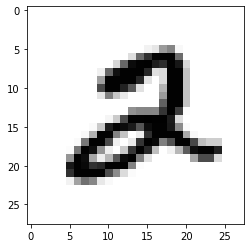

In [ ]:
dig = x_train[5]
plt.imshow(dig, cmap=matplotlib.cm.binary)
plt.show
print('Label :', y_train[5])
print('Trainning sample :')

### Data Binarization

Our problem is a multiclass classification, so we decided to binarize the target labels to preserve most of the information in the prediction phase. This process transform each target (one single value) into a one-hot encoded vector of 10 classes.    

In [ ]:
# Binarize y-sets
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_train_bin = label_binarize(y_train, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

print(x_train.shape)
print(y_train_bin.shape)

(60000, 28, 28)
(60000, 10)


### Build a model

The first model is a fully-connected multi-layer perceptron consisting of 3 hidden layers, with 120, 84 and 10 units respectively. We use ReLU for the activation of the two first hidden layers, then a softmax function in the last one to get outputs between 0 and 1. We choose categorical cross-entropy as a loss function and stocastic gradient descent to optimize it. The metrics used to monitor the performance of the model are categorical accuracy, area under the curve, precision and recall. 

In [ ]:
def create_model():  
  model = tf.keras.Sequential([
          layers.Flatten(input_shape=(28,28)),
          layers.Dense(120, activation="relu"),
          layers.Dense(84, activation="relu"),
          layers.Dense(10, activation='softmax')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                loss=tf.keras.losses.CategoricalCrossentropy(), 
                metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                tf.keras.metrics.AUC(name='auc'),                
                tf.keras.metrics.Precision(name='prec'),
                tf.keras.metrics.Recall(name='rec')
                ])
  return model

### Training

For the trainning phase we use cross-validation with 20% of the training set to be used as validation data. Initially, we set the number of epochs to 50 and stop the trainning when the validation loss stabilize.  

In [ ]:
model = create_model()
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
history = model.fit(x_train, y_train_bin, validation_split=0.2, epochs=50, callbacks=callbacks)

Epoch 1/50
1500/1500 [==============================] - 8s 4ms/step - loss: 0.4080 - acc: 0.8744 - auc: 0.9842 - prec: 0.9123 - rec: 0.8451 - val_loss: 0.2272 - val_acc: 0.9383 - val_auc: 0.9934 - val_prec: 0.9525 - val_rec: 0.9277
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1798 - acc: 0.9486 - auc: 0.9956 - prec: 0.9593 - rec: 0.9389 - val_loss: 0.1726 - val_acc: 0.9530 - val_auc: 0.9952 - val_prec: 0.9619 - val_rec: 0.9448
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1613 - acc: 0.9549 - auc: 0.9961 - prec: 0.9645 - rec: 0.9465 - val_loss: 0.1942 - val_acc: 0.9486 - val_auc: 0.9950 - val_prec: 0.9609 - val_rec: 0.9410
Epoch 4/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1510 - acc: 0.9582 - auc: 0.9962 - prec: 0.9684 - rec: 0.9511 - val_loss: 0.1886 - val_acc: 0.9542 - val_auc: 0.9945 - val_prec: 0.9671 - val_rec: 0.9463
Epoch 5/50
1500/1500 [==============================] - 6s 4ms/step - lo

### Validation Curve

If the training process is carried out over many epochs there is a risk of overfitting, which means the model adapts itself too much to the trainning data but is not able to generalize with new data. 

To overcome this we use a validation curve which compares the evolution of the accuracy on the training set and on the validation set versus the number of epochs used in the trainning. At the beginning of the curve both scores increase but at some point the accuracy in the validation set starts to decrease while the other keeps improving. We need to stop the trainning when both scores start to diverge. 

In [ ]:
#Plot validation curve
def plot_val_curve(history, title):
  nb_epoch = len(history.history.get('acc'))
  x = np.linspace(0, nb_epoch, num=nb_epoch)  
  y = history.history.get('acc')
  y2 = history.history.get('val_acc')
  plt.figure()
  plt.plot(x, y)
  plt.plot(x, y2)
  ax = plt.subplot(111)  
  ax.plot(x, y, label='Acc_train')
  ax.plot(x, y2, label='Acc_valid')
  plt.title(title)
  ax.legend()
  plt.xlabel('Nb Epoch')
  plt.ylabel('Acccuracy')
  plt.grid()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


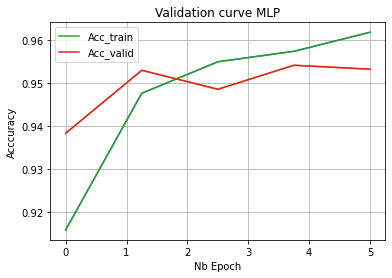

In [ ]:
plot_val_curve(history, 'Validation curve MLP')

### Re-train the model 

As we can observe in the previous curve, the divergence takes place roughly after 5 epochs, so we re-train a new model (model_2) using a limit of 5 epochs. 

In [ ]:
model_2 = create_model()
history_2 = model_2.fit(x_train, y_train_bin, validation_split=0.2, epochs=5)

Epoch 1/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3917 - acc: 0.8793 - auc: 0.9860 - prec: 0.9139 - rec: 0.8536 - val_loss: 0.2840 - val_acc: 0.9295 - val_auc: 0.9898 - val_prec: 0.9412 - val_rec: 0.9191
Epoch 2/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1967 - acc: 0.9444 - auc: 0.9951 - prec: 0.9556 - rec: 0.9352 - val_loss: 0.2090 - val_acc: 0.9403 - val_auc: 0.9951 - val_prec: 0.9562 - val_rec: 0.9294
Epoch 3/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1652 - acc: 0.9538 - auc: 0.9957 - prec: 0.9638 - rec: 0.9462 - val_loss: 0.2238 - val_acc: 0.9434 - val_auc: 0.9933 - val_prec: 0.9569 - val_rec: 0.9345
Epoch 4/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1440 - acc: 0.9619 - auc: 0.9961 - prec: 0.9717 - rec: 0.9546 - val_loss: 0.2381 - val_acc: 0.9471 - val_auc: 0.9926 - val_prec: 0.9577 - val_rec: 0.9400
Epoch 5/5
1500/1500 [==============================] - 6s 4ms/step - loss: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


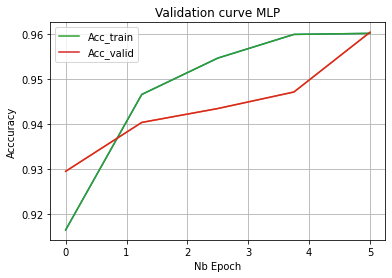

In [ ]:
plot_val_curve(history_2, 'Validation curve MLP')

This is the validation curve after we have fixed the epoch to 5.

## Measure Statistics

### Evaluation

For the evaluation of the model we consider metrics like loss, accuracy, precision, recall, received operating curves ROC and the area under the curve AUC using the test set. Keras provides a convenient way to check the performance of a model by using the 'model.evaluate' function. 

In [ ]:
metric_names = model_2.metrics_names
metric_names

['loss', 'acc', 'auc', 'prec', 'rec']

In [ ]:
metrics = model_2.evaluate(x_test, y_test_bin)

313/313 [==============================] - 1s 3ms/step - loss: 0.1748 - acc: 0.9594 - auc: 0.9947 - prec: 0.9694 - rec: 0.9516


In [ ]:
#Print metrics
for met_name, met_val in zip(metric_names, metrics):
  print(met_name, ' : ', met_val)

loss  :  0.174848273396492
acc  :  0.9593999981880188
auc  :  0.9946989417076111
prec  :  0.9694376587867737
rec  :  0.9516000151634216


The general accuracy of the model seems to be quite good (96%) since this model has not been optimized. ..............

### F1 Score

F1 score is a global metric but keras works in batches which may cause misleadings. It is depreciated in frameworks like keras, however, we decided to computed it to have an idea of its value.

In [ ]:
def f1_score(precision, recall):    
    return 2 * ((precision * recall) / (precision + recall))

In [ ]:
prec = metrics[3]
recall = metrics[4]

f1 = f1_score(prec, recall)
print('F1 score : ', f1)

F1 score :  0.9604360219594558


We get a F1 score of 0.9605, it is the harmonic mean of  precision and recall.So the value is kind of like the average of precision and recall (between 0.954 and 0.968), but as we stated before, this value is only considered as reference due to its nature. 

### ROC curve and AUC (Multiclass classification)

The Receiver Operating Characteristic curve (ROC) is a graphical tool that permits to visualize the performance of a classifier by comparing the False positive rate (FPR) and True positive rate (TPR) for several bias thresholds.





In [ ]:
# Compute predictions over x_test
y_pred = model_2.predict(x_test)

As ROC is intended to work with binary classifiers, we overcome this limitation by computing the FPR and the TPR for each class (that is for all the digits) as an individual binary classifier. For that we use the scikit-learn 'roc_curve' function. The code to compute and plot ROC curves has been adapted and modified from https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/

In [ ]:
# Compute ROC curve and ROC area for each class
nb_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

Then we use the FPR and TPR for all the classes to find the area under the curve.

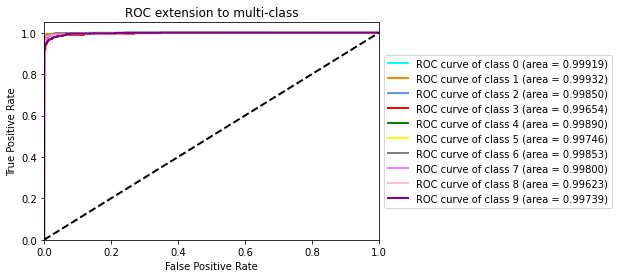

In [ ]:
# Plot all ROC curves
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
line_width = 2

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'gray', 'violet', 'pink', 'purple'])
for i, color in zip(range(nb_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC extension to multi-class')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

This curve shows the area for all the classes of the digits.The graph is a unclear because all the classes overlapped with each other.

We plot a zoomed view of the top-left region of the curve.


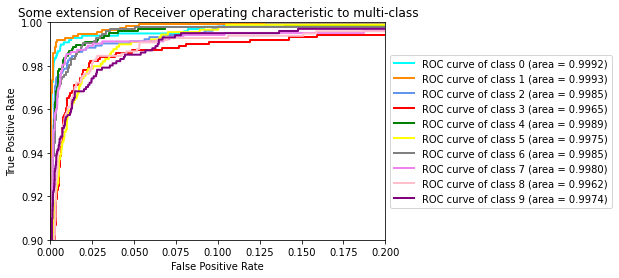

In [ ]:
# Zoomed ROC plot
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.9, 1)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'gray', 'violet', 'pink', 'purple'])
for i, color in zip(range(nb_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Above we can observe the ROC curve and associated AUC for each class as an individual classifier using the OneVsAll approach. In general, the performance of each classifier is pretty good, this is confirmed by the values of AUC for each one. However, there are still slight differences. For instance, the classifiers for the class 0 and 1 seems to be the most performant ones, with AUC values of 0.9996 and 0.9993, whereas classifiers for classes 8 and 9 exhibit the lower AUC values.

This means that classifiers 0 and 1 have very high TPR while keeping very low FPR values.

# Part II : Training with a LeNet on MNIST Dataset

### Build LeNet5 Model

The second model is a convolutional neural network (CNN) inspired in the LeNet5 architecture. Our model consist of 3 convolutional and 3 fully-connected layers,
along two maxpooling operations after the first and second convolution. For the convolutional layers we use 6, 16 and 120 filters with kernel sizes of 5x5 and 3x3 for the third layer. The fully-connected layers have 120, 84 and 10 units respectively. ReLU is used in all the layers, except the last one which uses softmax function. We choose categorical cross-entropy as a loss function and 'Adam' as the optimizer. The metrics used to monitor the performance of the model are categorical accuracy, area under the curve, precision and recall. 

In [ ]:
def create_model_cnn():
  model = tf.keras.Sequential([
          layers.Conv2D(filters=6, kernel_size=(5,5),strides=(1, 1), activation='relu', input_shape=(28,28,1),padding = "same"),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding = 'valid'),
          layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
          layers.Flatten(),
          layers.Dense(units=120, activation="relu"),
          layers.Dense(units=84, activation="relu"),
          layers.Dense(units=10, activation="softmax"),
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(), 
                loss=tf.keras.losses.CategoricalCrossentropy(), 
                metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                        tf.keras.metrics.AUC(name='auc'),                
                        tf.keras.metrics.Precision(name='prec'),
                        tf.keras.metrics.Recall(name='rec')
                ])
  model.summary()
  return model

In [ ]:
model_cnn = create_model_cnn()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

### Training

Before the trainning of the model we download the dataset again and get the the train and test set, and the labels as in Part I. 



In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

For the trainning, we use cross-validation with 20% of the training set to be used as validation data. Initially, we set the number of epochs to 50 and stop the trainning when the validation loss stabilize. 

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
history_cnn = model_cnn.fit(x_train, y_train_bin, epochs=50,batch_size = 128, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
375/375 [==============================] - 32s 83ms/step - loss: 0.7385 - acc: 0.7785 - auc: 0.9560 - prec: 0.8960 - rec: 0.6491 - val_loss: 0.1009 - val_acc: 0.9693 - val_auc: 0.9986 - val_prec: 0.9739 - val_rec: 0.9651
Epoch 2/50
375/375 [==============================] - 31s 82ms/step - loss: 0.0953 - acc: 0.9712 - auc: 0.9985 - prec: 0.9768 - rec: 0.9671 - val_loss: 0.0743 - val_acc: 0.9771 - val_auc: 0.9992 - val_prec: 0.9810 - val_rec: 0.9745
Epoch 3/50
375/375 [==============================] - 31s 82ms/step - loss: 0.0639 - acc: 0.9801 - auc: 0.9992 - prec: 0.9824 - rec: 0.9778 - val_loss: 0.0649 - val_acc: 0.9802 - val_auc: 0.9988 - val_prec: 0.9827 - val_rec: 0.9782
Epoch 4/50
375/375 [==============================] - 31s 82ms/step - loss: 0.0490 - acc: 0.9845 - auc: 0.9995 - prec: 0.9861 - rec: 0.9824 - val_loss: 0.0533 - val_acc: 0.9831 - val_auc: 0.9992 - val_prec: 0.9849 - val_rec: 0.9809
Epoch 5/50
375/375 [==============================] - 31s 82ms/step - lo

### Validation Curve

We use again the validation curve to stop trainning before overfitting.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


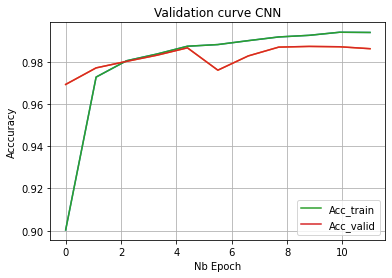

In [ ]:
plot_val_curve(history_cnn, 'Validation curve CNN')

### Re-train the model

As we can observe in the previous curve, the divergence takes place roughly after only 5 epochs, so we re-train a new model (model_cnn_2) using a limit of 5 epochs. 

In [ ]:
model_cnn_2 = create_model_cnn()
history_cnn_2 = model_cnn_2.fit(x_train, y_train_bin, validation_split=0.2, epochs=5,batch_size=128)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_10 (Dense)             (None, 84)               

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


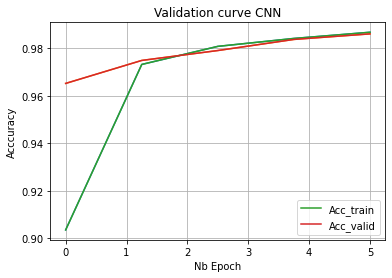

In [ ]:
plot_val_curve(history_cnn_2, 'Validation curve CNN')

This is the validation curve after we fixed the epoch to 5.

## Measure Statistics

### Evaluation

For the evaluation of the model we consider metrics like loss, accuracy, precision, recall, received operating curves ROC and the area under the curve AUC using the test set.

In [ ]:
metric_names = model_cnn_2.metrics_names
metric_names



x_test = x_test.reshape(-1, 28, 28, 1)

metrics = model_cnn_2.evaluate(x_test, y_test_bin)
#Print metrics
print('\n Metrics ')
for met_name, met_val in zip(metric_names, metrics):
  print(met_name, ' : ', met_val)

313/313 [==============================] - 4s 13ms/step - loss: 0.0351 - acc: 0.9891 - auc: 0.9996 - prec: 0.9901 - rec: 0.9877

 Metrics 
loss  :  0.03510894626379013
acc  :  0.9890999794006348
auc  :  0.9995548129081726
prec  :  0.9900761842727661
rec  :  0.9876999855041504


The overall accuracy for LeNet CNN (98%) is greater than the ~96% which we obtained in MLP.



### F1 Score

In [ ]:
prec_cnn = metrics[3]
recall_cnn = metrics[4]

f1 = f1_score(prec_cnn, recall_cnn)
print('F1 score : ', f1)

F1 score :  0.9888866574466996


### Comparing the performance of MLP with LeNet

In [ ]:
#Reference : https://medium.com/the-owl/multilayer-perceptron-model-vs-cnn-5be5cf87897a#:~:text=not%20linearly%20separable.-,Multilayer%20Perceptron%20(MLP),connected%20with%20every%20other%20perceptron.

def plot_training(history,title):
    fig, axs = plt.subplots(1,2,figsize=(16,5)) 
    plot_heading1 = 'Model Accuracy for '+title
    plot_heading2 = 'Model Loss for '+title
    axs[0].plot(history.history['acc'], 'c') 
    axs[0].set_title(plot_heading1) 
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch') 
    axs[0].legend(['train', 'validate'], loc='upper left') 
    
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].set_title(plot_heading2) 
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch') 
    axs[1].legend(['train', 'validate'], loc='upper right') 
    plt.show()

We will plot 2 graphs for LeNet.In one graph we will see how accuracy changes with epoch.In other plot we will see how loss changes with epoch.

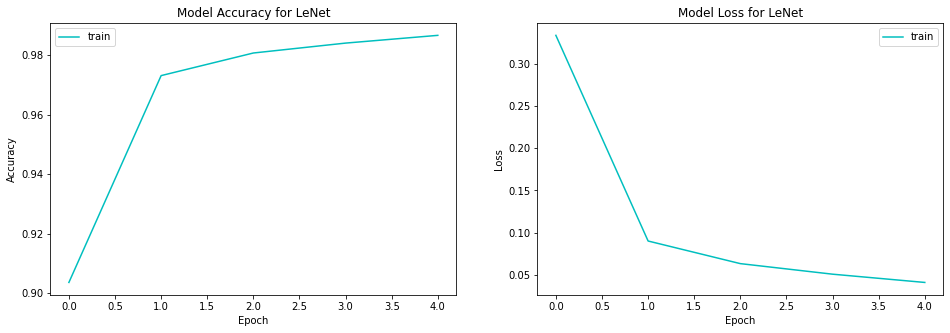

In [ ]:
plot_training(history_cnn_2,"LeNet")

Similarly we will plot 2 graphs for MLP.In one graph we will see how accuracy changes with epoch.In other plot we will see how loss changes with epoch.

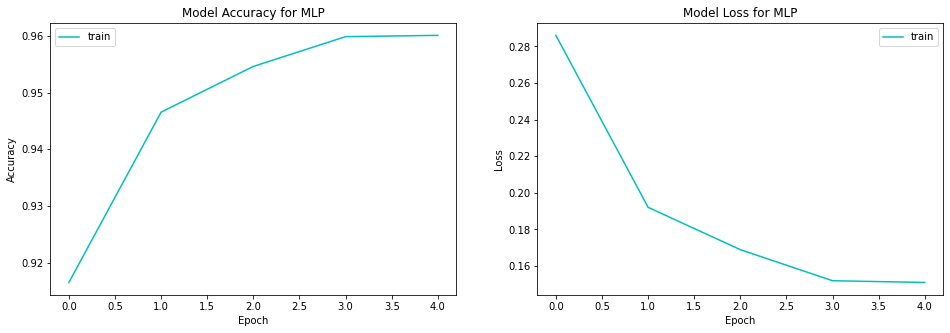

In [ ]:
plot_training(history_2,"MLP")

Clearly from the above graphs we can see that LeNet converges faster than MLP with every epoch.However every epoch of LeNet (CNN) takes longer time compared to MLP.

### ROC curve and AUC (Multiclass classification)

For the computation of the ROC and AUC we follow the same procedure as Part I.

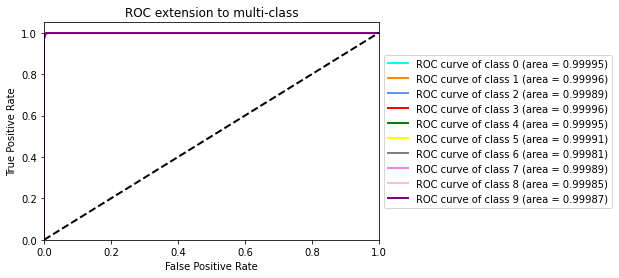

In [ ]:
# Compute predictions over x_test
y_pred_cnn = model_cnn_2.predict(x_test)

# Compute ROC curve and ROC area for each class
nb_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_cnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
line_width = 2

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'gray', 'violet', 'pink', 'purple'])
for i, color in zip(range(nb_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC extension to multi-class')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

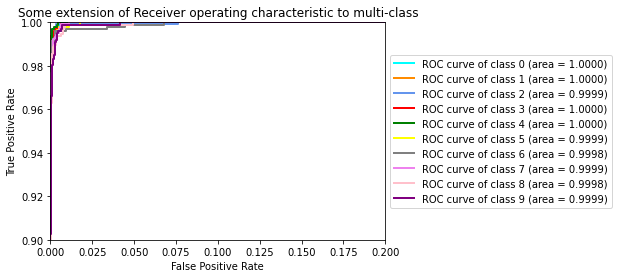

In [ ]:
# Zoomed ROC plot
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.9, 1)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'gray', 'violet', 'pink', 'purple'])
for i, color in zip(range(nb_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Modifying parameters of fully connected multi-layer network
#### Modifying number of layers and number of units per layer

In [ ]:
from sklearn.metrics import f1_score as sk_f1_score

units_per_layer = np.array((10,20,50,100))
number_of_layers = np.array((1,2,3))

accuracies = np.zeros((len(number_of_layers),len(units_per_layer)))
precisions = np.copy(accuracies)
recalls = np.copy(accuracies)
f1s = np.copy(accuracies)
rocaucs = np.copy(accuracies)

for i,l in enumerate(number_of_layers):
    for j,u in enumerate(units_per_layer):
        print("Training with " + str(l) +" layers and " + str(u) + " units per layer...")
        model = tf.keras.Sequential([
                layers.Flatten(input_shape=(28,28)), 
                *[layers.Dense(u, activation="relu") for i in range(l)] ,
                layers.Dense(10, activation='softmax')
                ])
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
                loss=tf.keras.losses.SparseCategoricalCrossentropy())
                
        history = model.fit(x_train, y_train, batch_size=16, epochs=50, validation_split=0.2, callbacks=callbacks, verbose=0)

        y_pred = model.predict(x_test, batch_size=64, verbose=1)
        y_pred_bool = np.argmax(y_pred, axis=1)
        accuracies[i,j] = accuracy_score(y_test, y_pred_bool)
        precisions[i,j] = precision_score(y_test, y_pred_bool, average='weighted')
        recalls[i,j] = recall_score(y_test, y_pred_bool, average='weighted')
        f1s[i,j] = sk_f1_score(y_test, y_pred_bool, average='weighted')
        rocaucs[i,j] = roc_auc_score(y_test, y_pred, average='weighted', multi_class='ovr')

Training with 1 layers and 10 units per layer...
Epoch 00034: early stopping
157/157 [==============================] - 0s 1ms/step
Training with 1 layers and 20 units per layer...
Epoch 00049: early stopping
157/157 [==============================] - 0s 1ms/step
Training with 1 layers and 50 units per layer...
Epoch 00040: early stopping
157/157 [==============================] - 0s 1ms/step
Training with 1 layers and 100 units per layer...
Epoch 00045: early stopping
157/157 [==============================] - 0s 1ms/step
Training with 2 layers and 10 units per layer...
Epoch 00016: early stopping
157/157 [==============================] - 0s 1ms/step
Training with 2 layers and 20 units per layer...
Epoch 00022: early stopping
157/157 [==============================] - 0s 1ms/step
Training with 2 layers and 50 units per layer...
Epoch 00025: early stopping
157/157 [==============================] - 1s 3ms/step
Training with 2 layers and 100 units per layer...
Epoch 00024: early stoppi

Text(0.5, 0.98, 'Scores depending on number of units per layer (x-axis) and number of layers (y-axis)')

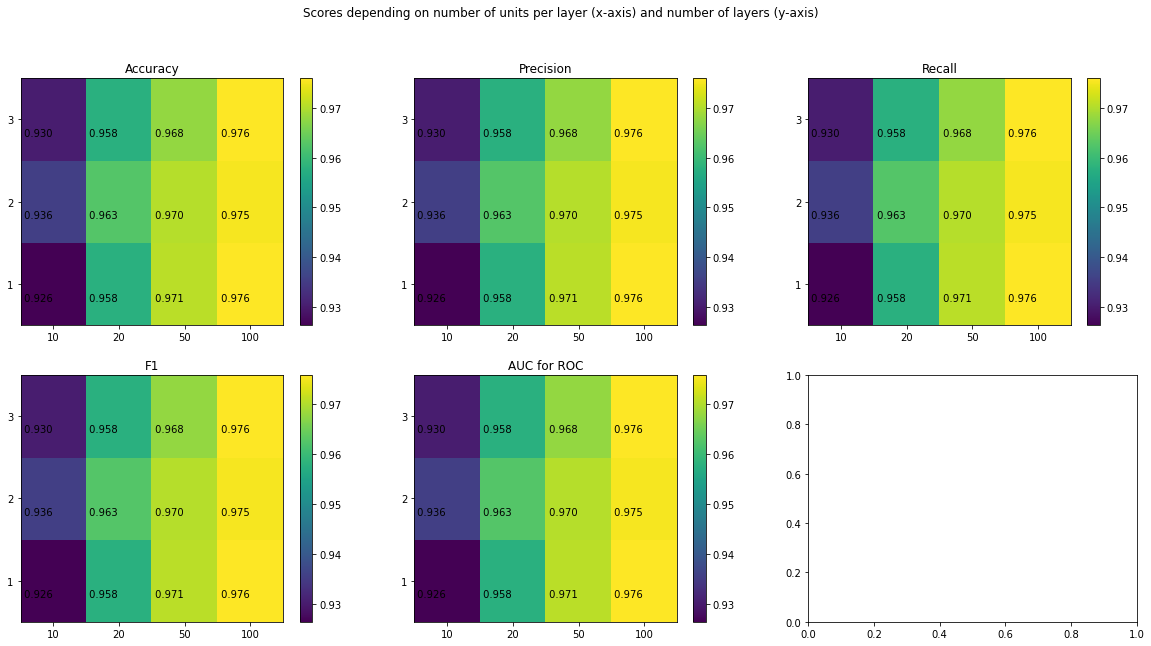

In [ ]:
import matplotlib.pyplot as plt
     
       
def print_colored_results(values, number_of_layers, units_per_layer, title, ax=None):
    #fig, ax = plt.subplots()
    if ax is None:
        ax = plt.gca() 
    im = ax.pcolormesh(np.arange(0.5, len(units_per_layer)+1, 1), np.arange(0.5, len(number_of_layers)+1, 1), accuracies)
    ax.set_xticklabels(units_per_layer, minor=False)
    ax.set_yticklabels(number_of_layers, minor=False)
    ax.set_xticks(np.arange(len(units_per_layer))+1, minor=False)
    ax.set_yticks(np.arange(len(number_of_layers))+1, minor=False)
    fig.colorbar(im, ax=ax)
    ax.set_title(title)

    for ii,i in enumerate(number_of_layers):
        for jj,j in enumerate(units_per_layer):
            ax.text(jj+0.5,ii+0.8," %.3f" % accuracies[ii][jj])
    
    return ax

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
print_colored_results(accuracies, number_of_layers, units_per_layer,'Accuracy', axs[0,0])
print_colored_results(precisions, number_of_layers, units_per_layer,'Precision', axs[0,1])
print_colored_results(recalls, number_of_layers, units_per_layer,'Recall', axs[0,2])
print_colored_results(f1s, number_of_layers, units_per_layer,'F1', axs[1,0])
print_colored_results(rocaucs, number_of_layers, units_per_layer,'AUC for ROC', axs[1,1])
fig.suptitle('Scores depending on number of units per layer (x-axis) and number of layers (y-axis)')

We can see that when the number of layers and the number of units per layer increase, all the score increase.
But with a low number of units per layer (10), the performance of the network doesn't increase when the number of layer increase.

#### Modifying the learning rate

In [ ]:
learning_rates = [0.5,0.1,0.01,0.001]

losses = []
for l in learning_rates:
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28,28)),
        layers.Dense(120, activation="relu"),
        layers.Dense(84, activation="relu"),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=l), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')
              ])
    history = model.fit(x_train, y_train, batch_size=16, epochs=20, validation_split=0.2, verbose = 0)
    
    losses.append(history.history["loss"])

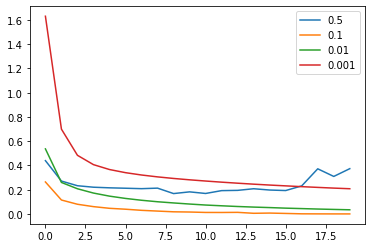

In [ ]:
for i, lr in enumerate(learning_rates):
    plt.plot(losses[i], label=lr)
    plt.legend()

We can see in the figure above the evolution of the loss function with differents learning rate over multiple epoch.
When the learning rate is too low, the network is slower at learning and take more time to have proper performances and the performances are lower. But when the learning rate is too high, the algorithm doesn't seems to learn anything and get bad performance even after multiple epochs.